In [2]:

import torch
import torchvision
from torchvision import transforms
import matplotlib.pyplot as plt
import torchvision.datasets as datasets
import torchvision.transforms as transforms



In [3]:
# Define transformations for CIFAR-10
transform = transforms.Compose([
    transforms.Resize((32, 32)),  # Ensure images are resized to 32x32
    transforms.ToTensor(),       # Convert images to PyTorch tensors
    transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))  # Normalize to [-1, 1]
])


In [4]:
# Load CIFAR-10 dataset
train_dataset = datasets.CIFAR10(root='./data', train=True, transform=transform, download=True)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4, pin_memory=True)


100%|██████████| 170M/170M [00:13<00:00, 12.8MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


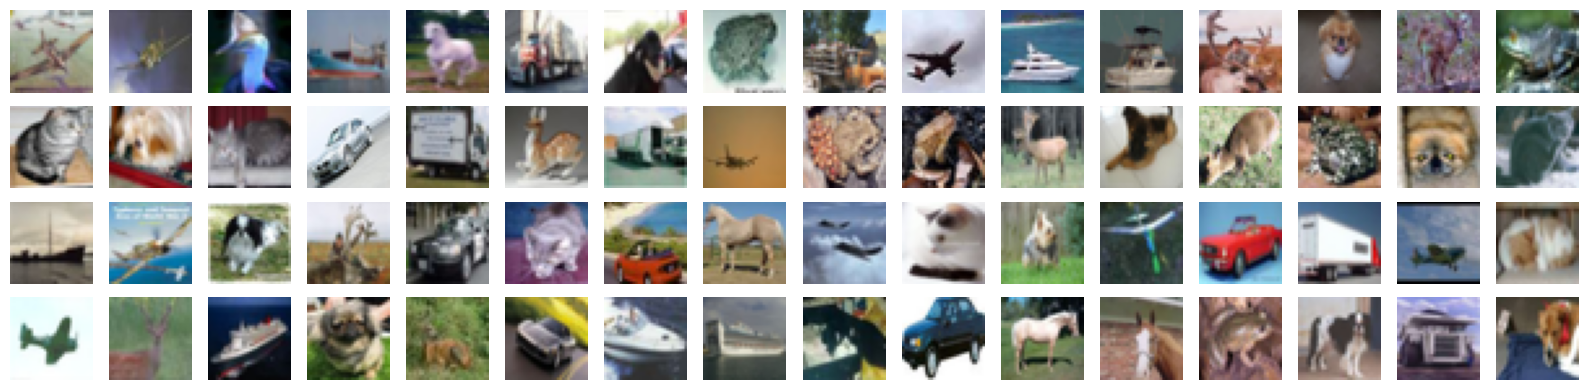

In [5]:
# Denormalization function
def denormalize(img):
    img = (img * 0.5) + 0.5  # Reverse the normalization (assuming mean=0.5, std=0.5)
    return img

unique_images, unique_labels = next(iter(train_loader))
unique_images = unique_images.permute(0, 2, 3, 1).numpy()  # Permute to (batch, height, width, channels)
unique_images = denormalize(unique_images)  # Denormalize to [0, 1]

fig, axes = plt.subplots(4, 16, figsize=(16, 4), sharex=True, sharey=True)  # Create a 4x16 grid of subplots with a wider figure

for i in range(4):  # Loop over rows
    for j in range(16):  # Loop over columns
        index = i * 16 + j  # Calculate the index in the batch
        axes[i, j].imshow(unique_images[index])  # Show the image
        axes[i, j].axis('off')  # Turn off axis labels and ticks

plt.tight_layout()
plt.show()


In [6]:
%%capture

# Install the 'einops' library for easy manipulation of tensors
!pip install einops

# Install the 'lpips' library for computing perceptual similarity between images
!pip install lpips

In [7]:
# Import the PyTorch library for tensor operations.
import torch

# Import the neural network module from PyTorch.
import torch.nn as nn

# Import functional operations from PyTorch.
import torch.nn.functional as F

# Import the 'numpy' library for numerical operations.
import numpy as np

# Import the 'functools' module for higher-order functions.
import functools

# Import the Adam optimizer from PyTorch.
from torch.optim import Adam

# Import the DataLoader class from PyTorch for handling datasets.
from torch.utils.data import DataLoader

# Import data transformation functions from torchvision.
import torchvision.transforms as transforms

# Import the CIFAR10 dataset from torchvision.
from torchvision.datasets import CIFAR10

# Import 'tqdm' for creating progress bars during training.
import tqdm

# Import 'trange' and 'tqdm' specifically for notebook compatibility.
from tqdm.notebook import trange, tqdm

# Import the learning rate scheduler from PyTorch.
from torch.optim.lr_scheduler import MultiplicativeLR, LambdaLR

# Import the 'matplotlib.pyplot' library for plotting graphs.
import matplotlib.pyplot as plt

# Import the 'make_grid' function from torchvision.utils for visualizing image grids.
from torchvision.utils import make_grid

# Importing the `rearrange` function from the `einops` library
from einops import rearrange

# Importing the `math` module for mathematical operations
import math

In [8]:
# Forward diffusion for N steps in 1D.
def forward_diffusion_1D(x0, noise_strength_fn, t0, nsteps, dt):
    """
    Parameters:
    - x0: Initial sample value (scalar)
    - noise_strength_fn: Function of time, outputs scalar noise strength
    - t0: Initial time
    - nsteps: Number of diffusion steps
    - dt: Time step size

    Returns:
    - x: Trajectory of sample values over time
    - t: Corresponding time points for the trajectory
    """

    # Initialize the trajectory array
    x = np.zeros(nsteps + 1)

    # Set the initial sample value
    x[0] = x0

    # Generate time points for the trajectory
    t = t0 + np.arange(nsteps + 1) * dt

    # Perform Euler-Maruyama time steps for diffusion simulation
    for i in range(nsteps):

        # Get the noise strength at the current time
        noise_strength = noise_strength_fn(t[i])

        # Generate a random normal variable
        random_normal = np.random.randn()

        # Update the trajectory using Euler-Maruyama method
        x[i + 1] = x[i] + random_normal * noise_strength

    # Return the trajectory and corresponding time points
    return x, t

In [9]:
# Example noise strength function: always equal to 1
def noise_strength_constant(t):
    """
    Example noise strength function that returns a constant value (1).

    Parameters:
    - t: Time parameter (unused in this example)

    Returns:
    - Constant noise strength (1)
    """
    return 1

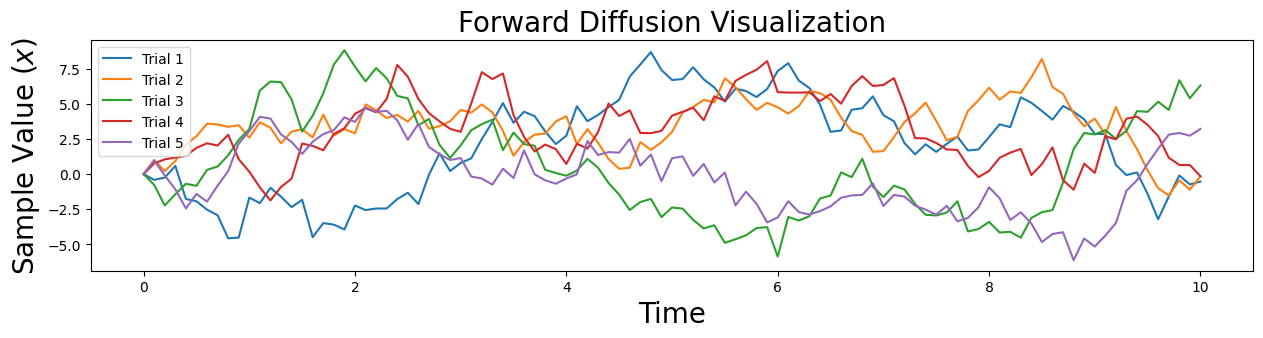

In [10]:
# Number of diffusion steps
nsteps = 100

# Initial time
t0 = 0

# Time step size
dt = 0.1

# Noise strength function
noise_strength_fn = noise_strength_constant

# Initial sample value
x0 = 0

# Number of tries for visualization
num_tries = 5

# Setting larger width and smaller height for the plot
plt.figure(figsize=(15, 3))

# Loop for multiple trials
for i in range(num_tries):

    # Simulate forward diffusion
    x, t = forward_diffusion_1D(x0, noise_strength_fn, t0, nsteps, dt)

    # Plot the trajectory
    plt.plot(t, x, label=f'Trial {i+1}')  # Adding a label for each trial

# Labeling the plot
plt.xlabel('Time', fontsize=20)
plt.ylabel('Sample Value ($x$)', fontsize=20)

# Title of the plot
plt.title('Forward Diffusion Visualization', fontsize=20)

# Adding a legend to identify each trial
plt.legend()

# Show the plot
plt.show()


In [11]:
# Reverse diffusion for N steps in 1D.
def reverse_diffusion_1D(x0, noise_strength_fn, score_fn, T, nsteps, dt):
    """
    Parameters:
    - x0: Initial sample value (scalar)
    - noise_strength_fn: Function of time, outputs scalar noise strength
    - score_fn: Score function
    - T: Final time
    - nsteps: Number of diffusion steps
    - dt: Time step size

    Returns:
    - x: Trajectory of sample values over time
    - t: Corresponding time points for the trajectory
    """

    # Initialize the trajectory array
    x = np.zeros(nsteps + 1)

    # Set the initial sample value
    x[0] = x0

    # Generate time points for the trajectory
    t = np.arange(nsteps + 1) * dt

    # Perform Euler-Maruyama time steps for reverse diffusion simulation
    for i in range(nsteps):

        # Calculate noise strength at the current time
        noise_strength = noise_strength_fn(T - t[i])

        # Calculate the score using the score function
        score = score_fn(x[i], 0, noise_strength, T - t[i])

        # Generate a random normal variable
        random_normal = np.random.randn()

        # Update the trajectory using the reverse Euler-Maruyama method
        x[i + 1] = x[i] + score * noise_strength**2 * dt + noise_strength * random_normal * np.sqrt(dt)

    # Return the trajectory and corresponding time points
    return x, t

In [12]:
# Example score function: always equal to 1
def score_simple(x, x0, noise_strength, t):
    """
    Parameters:
    - x: Current sample value (scalar)
    - x0: Initial sample value (scalar)
    - noise_strength: Scalar noise strength at the current time
    - t: Current time

    Returns:
    - score: Score calculated based on the provided formula
    """

    # Calculate the score using the provided formula
    score = - (x - x0) / ((noise_strength**2) * t)

    # Return the calculated score
    return score

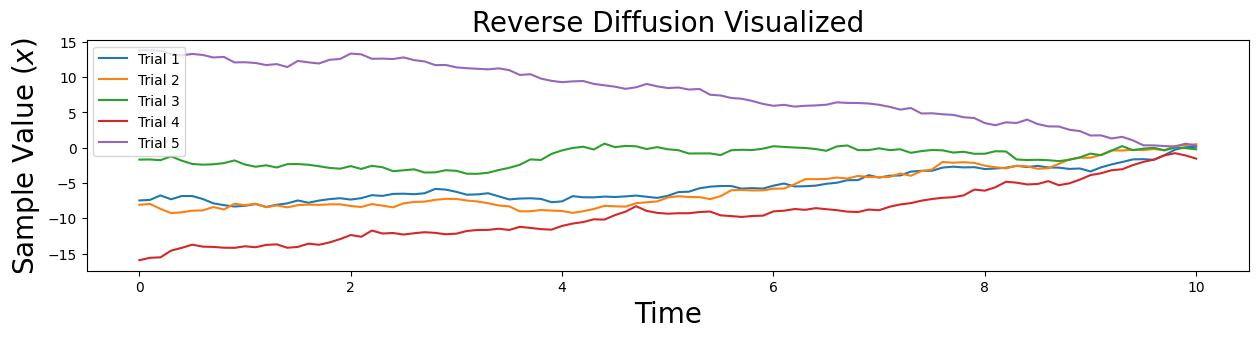

In [13]:
# Number of reverse diffusion steps
nsteps = 100

# Initial time for reverse diffusion
t0 = 0

# Time step size for reverse diffusion
dt = 0.1

# Function defining constant noise strength for reverse diffusion
noise_strength_fn = noise_strength_constant

# Example score function for reverse diffusion
score_fn = score_simple

# Initial sample value for reverse diffusion
x0 = 0

# Final time for reverse diffusion
T = 11

# Number of tries for visualization
num_tries = 5

# Setting larger width and smaller height for the plot
plt.figure(figsize=(15, 3))

# Loop for multiple trials
for i in range(num_tries):
    # Draw from the noise distribution, which is diffusion for time T with noise strength 1
    x0 = np.random.normal(loc=0, scale=T)

    # Simulate reverse diffusion
    x, t = reverse_diffusion_1D(x0, noise_strength_fn, score_fn, T, nsteps, dt)

    # Plot the trajectory
    plt.plot(t, x, label=f'Trial {i+1}')  # Adding a label for each trial

# Labeling the plot
plt.xlabel('Time', fontsize=20)
plt.ylabel('Sample Value ($x$)', fontsize=20)

# Title of the plot
plt.title('Reverse Diffusion Visualized', fontsize=20)

# Adding a legend to identify each trial
plt.legend()

# Show the plot
plt.show()

In [14]:
# Define a module for Gaussian random features used to encode time steps.
class GaussianFourierProjection(nn.Module):
    def __init__(self, embed_dim, scale=30.):
        """
        Parameters:
        - embed_dim: Dimensionality of the embedding (output dimension)
        - scale: Scaling factor for random weights (frequencies)
        """
        super().__init__()

        # Randomly sample weights (frequencies) during initialization.
        # These weights (frequencies) are fixed during optimization and are not trainable.
        self.W = nn.Parameter(torch.randn(embed_dim // 2) * scale, requires_grad=False)

    def forward(self, x):
        """
        Parameters:
        - x: Input tensor representing time steps
        """
        # Calculate the cosine and sine projections: Cosine(2 pi freq x), Sine(2 pi freq x)
        x_proj = x[:, None] * self.W[None, :] * 2 * np.pi

        # Concatenate the sine and cosine projections along the last dimension
        return torch.cat([torch.sin(x_proj), torch.cos(x_proj)], dim=-1)

In [15]:
# Define a module for a fully connected layer that reshapes outputs to feature maps.
class Dense(nn.Module):
    def __init__(self, input_dim, output_dim):
        """
        Parameters:
        - input_dim: Dimensionality of the input features
        - output_dim: Dimensionality of the output features
        """
        super().__init__()

        # Define a fully connected layer
        self.dense = nn.Linear(input_dim, output_dim)

    def forward(self, x):
        """
        Parameters:
        - x: Input tensor

        Returns:
        - Output tensor after passing through the fully connected layer
          and reshaping to a 4D tensor (feature map)
        """

        # Apply the fully connected layer and reshape the output to a 4D tensor
        return self.dense(x)[..., None, None]
        # This broadcasts the 2D tensor to a 4D tensor, adding the same value across space.

In [16]:
# Define a time-dependent score-based model built upon the U-Net architecture.
class UNet(nn.Module):
    def __init__(self, marginal_prob_std, channels=[32, 64, 128, 256], embed_dim=256):
        """
        Initialize a time-dependent score-based network.

        Parameters:
        - marginal_prob_std: A function that gives the standard deviation
          of the perturbation kernel p_{0t}(x(t) | x(0)).
        - channels: The number of channels for feature maps of each resolution.
        - embed_dim: The dimensionality of Gaussian random feature embeddings.
        """
        super().__init__()

        # Gaussian random feature embedding layer for time
        self.time_embed = nn.Sequential(
            GaussianFourierProjection(embed_dim=embed_dim),
            nn.Linear(embed_dim, embed_dim)
        )

        # Encoding layers where the resolution decreases
        self.conv1 = nn.Conv2d(3, channels[0], kernel_size=3, stride=1, padding=1, bias=False)
        self.dense1 = Dense(embed_dim, channels[0])
        self.gnorm1 = nn.GroupNorm(4, num_channels=channels[0])

        self.conv2 = nn.Conv2d(channels[0], channels[1], kernel_size=3, stride=2, padding=1, bias=False)
        self.dense2 = Dense(embed_dim, channels[1])
        self.gnorm2 = nn.GroupNorm(32, num_channels=channels[1])

        self.conv3 = nn.Conv2d(channels[1], channels[2], kernel_size=3, stride=2, padding=1, bias=False)
        self.dense3 = Dense(embed_dim, channels[2])
        self.gnorm3 = nn.GroupNorm(32, num_channels=channels[2])

        self.conv4 = nn.Conv2d(channels[2], channels[3], kernel_size=3, stride=2, padding=1, bias=False)
        self.dense4 = Dense(embed_dim, channels[3])
        self.gnorm4 = nn.GroupNorm(32, num_channels=channels[3])

        # Decoding layers where the resolution increases
        self.tconv4 = nn.ConvTranspose2d(channels[3], channels[2], kernel_size=3, stride=2, padding=1, output_padding=1, bias=False)
        self.dense5 = Dense(embed_dim, channels[2])
        self.tgnorm4 = nn.GroupNorm(32, num_channels=channels[2])

        self.tconv3 = nn.ConvTranspose2d(channels[2] * 2, channels[1], kernel_size=3, stride=2, padding=1, output_padding=1, bias=False)
        self.dense6 = Dense(embed_dim, channels[1])
        self.tgnorm3 = nn.GroupNorm(32, num_channels=channels[1])

        self.tconv2 = nn.ConvTranspose2d(channels[1] * 2, channels[0], kernel_size=3, stride=2, padding=1, output_padding=1, bias=False)
        self.dense7 = Dense(embed_dim, channels[0])
        self.tgnorm2 = nn.GroupNorm(32, num_channels=channels[0])

        self.tconv1 = nn.ConvTranspose2d(channels[0] * 2, 1, kernel_size=3, stride=1, padding=1)

        # The swish activation function
        self.act = lambda x: x * torch.sigmoid(x)
        self.marginal_prob_std = marginal_prob_std

    def forward(self, x, t, y=None):
      """
      Forward pass of the UNet model.

      Parameters:
      - x: Input tensor.
      - t: Time tensor.
      - y: Optional target tensor.

      Returns:
      - h: Output tensor after passing through the UNet architecture.
      """
      # Obtain the Gaussian random feature embedding for time t
      embed = self.act(self.time_embed(t))

      # Encoding path
      h1 = self.conv1(x) + self.dense1(embed)
      h1 = self.act(self.gnorm1(h1))
      h2 = self.conv2(h1) + self.dense2(embed)
      h2 = self.act(self.gnorm2(h2))
      h3 = self.conv3(h2) + self.dense3(embed)
      h3 = self.act(self.gnorm3(h3))
      h4 = self.conv4(h3) + self.dense4(embed)
      h4 = self.act(self.gnorm4(h4))

      # Decoding path
      h = self.tconv4(h4) + self.dense5(embed)
      h = self.act(self.tgnorm4(h))

      # Ensure matching dimensions before concatenating h and h3
      if h.size(-1) != h3.size(-1) or h.size(-2) != h3.size(-2):
          h3 = F.interpolate(h3, size=(h.size(-2), h.size(-1)), mode="nearest")

      h = self.tconv3(torch.cat([h, h3], dim=1)) + self.dense6(embed)
      h = self.act(self.tgnorm3(h))

      # Ensure matching dimensions before concatenating h and h2
      if h.size(-1) != h2.size(-1) or h.size(-2) != h2.size(-2):
          h2 = F.interpolate(h2, size=(h.size(-2), h.size(-1)), mode="nearest")

      h = self.tconv2(torch.cat([h, h2], dim=1)) + self.dense7(embed)
      h = self.act(self.tgnorm2(h))

      # Ensure matching dimensions before concatenating h and h1
      if h.size(-1) != h1.size(-1) or h.size(-2) != h1.size(-2):
          h1 = F.interpolate(h1, size=(h.size(-2), h.size(-1)), mode="nearest")

      h = self.tconv1(torch.cat([h, h1], dim=1))

      # Normalize the output
      h = h / self.marginal_prob_std(t)[:, None, None, None]
      return h

In [17]:
class UNet_res(nn.Module):
    def __init__(self, marginal_prob_std, channels=[32, 64, 128, 256], embed_dim=256):
        """
        Initialize the alternate UNet model.

        Parameters:
        - marginal_prob_std: A function that gives the standard deviation
          of the perturbation kernel p_{0t}(x(t) | x(0)).
        - channels: The number of channels for feature maps of each resolution.
        - embed_dim: The dimensionality of Gaussian random feature embeddings.
        """
        super().__init__()

        # Gaussian random feature embedding layer for time
        self.time_embed = nn.Sequential(
            GaussianFourierProjection(embed_dim=embed_dim),
            nn.Linear(embed_dim, embed_dim)
        )

        # Encoding layers where the resolution decreases
        self.conv1 = nn.Conv2d(3, channels[0], kernel_size=3, stride=1, padding=1, bias=False)  # Update input channels
        self.dense1 = Dense(embed_dim, channels[0])
        self.gnorm1 = nn.GroupNorm(4, num_channels=channels[0])

        self.conv2 = nn.Conv2d(channels[0], channels[1], kernel_size=3, stride=2, padding=1, bias=False)
        self.dense2 = Dense(embed_dim, channels[1])
        self.gnorm2 = nn.GroupNorm(32, num_channels=channels[1])

        self.conv3 = nn.Conv2d(channels[1], channels[2], kernel_size=3, stride=2, padding=1, bias=False)
        self.dense3 = Dense(embed_dim, channels[2])
        self.gnorm3 = nn.GroupNorm(32, num_channels=channels[2])

        self.conv4 = nn.Conv2d(channels[2], channels[3], kernel_size=3, stride=2, padding=1, bias=False)
        self.dense4 = Dense(embed_dim, channels[3])
        self.gnorm4 = nn.GroupNorm(32, num_channels=channels[3])

        # Decoding layers where the resolution increases
        self.tconv4 = nn.ConvTranspose2d(channels[3], channels[2], kernel_size=3, stride=2, padding=1, output_padding=1, bias=False)
        self.dense5 = Dense(embed_dim, channels[2])
        self.tgnorm4 = nn.GroupNorm(32, num_channels=channels[2])

        self.tconv3 = nn.ConvTranspose2d(channels[2], channels[1], kernel_size=3, stride=2, padding=1, output_padding=1, bias=False)
        self.dense6 = Dense(embed_dim, channels[1])
        self.tgnorm3 = nn.GroupNorm(32, num_channels=channels[1])

        self.tconv2 = nn.ConvTranspose2d(channels[1], channels[0], kernel_size=3, stride=2, padding=1, output_padding=1, bias=False)
        self.dense7 = Dense(embed_dim, channels[0])
        self.tgnorm2 = nn.GroupNorm(32, num_channels=channels[0])

        self.tconv1 = nn.ConvTranspose2d(channels[0], 1, kernel_size=3, stride=1, padding=1)

        # The swish activation function
        self.act = lambda x: x * torch.sigmoid(x)
        self.marginal_prob_std = marginal_prob_std

    def forward(self, x, t, y=None):
        """
        Parameters:
        - x: Input tensor
        - t: Time tensor
        - y: Target tensor (not used in this forward pass)

        Returns:
        - h: Output tensor after passing through the U-Net architecture
        """

        # Obtain the Gaussian random feature embedding for t
        embed = self.act(self.time_embed(t))

        # Encoding path
        h1 = self.conv1(x) + self.dense1(embed)
        h1 = self.act(self.gnorm1(h1))
        h2 = self.conv2(h1) + self.dense2(embed)
        h2 = self.act(self.gnorm2(h2))
        h3 = self.conv3(h2) + self.dense3(embed)
        h3 = self.act(self.gnorm3(h3))
        h4 = self.conv4(h3) + self.dense4(embed)
        h4 = self.act(self.gnorm4(h4))

        # Decoding path
        h = self.tconv4(h4)
        h += self.dense5(embed)
        h = self.act(self.tgnorm4(h))
        h = self.tconv3(h + h3)
        h += self.dense6(embed)
        h = self.act(self.tgnorm3(h))
        h = self.tconv2(h + h2)
        h += self.dense7(embed)
        h = self.act(self.tgnorm2(h))
        h = self.tconv1(h + h1)

        # Normalize output
        h = h / self.marginal_prob_std(t)[:, None, None, None]
        return h

In [18]:
# Using GPU
device = "cuda"

# Marginal Probability Standard Deviation Function
def marginal_prob_std(t, sigma):
    """
    Compute the mean and standard deviation of $p_{0t}(x(t) | x(0))$.

    Parameters:
    - t: A vector of time steps.
    - sigma: The $\sigma$ in our SDE.

    Returns:
    - The standard deviation.
    """
    # Convert time steps to a PyTorch tensor
    t = torch.tensor(t, device=device)
    #t = t.clone().detach().to(device)

    # Calculate and return the standard deviation based on the given formula
    return torch.sqrt((sigma**(2 * t) - 1.) / 2. / np.log(sigma))

In [19]:
# Using GPU
device = "cuda"

def diffusion_coeff(t, sigma):
    """
    Compute the diffusion coefficient of our SDE.

    Parameters:
    - t: A vector of time steps.
    - sigma: The $\sigma$ in our SDE.

    Returns:
    - The vector of diffusion coefficients.
    """
    # Calculate and return the diffusion coefficients based on the given formula
    return torch.tensor(sigma**t, device=device)


In [20]:
# Sigma Value
sigma =  25.0

# marginal probability standard
marginal_prob_std_fn = functools.partial(marginal_prob_std, sigma=sigma)

# diffusion coefficient
diffusion_coeff_fn = functools.partial(diffusion_coeff, sigma=sigma)

In [21]:
def loss_fn(model, x, marginal_prob_std, eps=1e-5):
    """
    The loss function for training score-based generative models.

    Parameters:
    - model: A PyTorch model instance that represents a time-dependent score-based model.
    - x: A mini-batch of training data.
    - marginal_prob_std: A function that gives the standard deviation of the perturbation kernel.
    - eps: A tolerance value for numerical stability.
    """
    # Sample time uniformly in the range (eps, 1-eps)
    random_t = torch.rand(x.shape[0], device=x.device) * (1. - 2 * eps) + eps
    # Find the noise std at the sampled time `t`
    std = marginal_prob_std(random_t)

    # Generate normally distributed noise
    z = torch.randn_like(x)

    # Perturb the input data with the generated noise
    perturbed_x = x + z * std[:, None, None, None]

    # Get the score from the model using the perturbed data and time
    score = model(perturbed_x, random_t)

    # Ensure score and noise have matching dimensions
    if score.size() != z.size():
        z = F.interpolate(z, size=score.shape[2:], mode='bilinear', align_corners=False)

    # Calculate the loss based on the score and noise
    loss = torch.mean(torch.sum((score * std[:, None, None, None] + z)**2, dim=(1, 2, 3)))

    return loss


In [30]:
def Euler_Maruyama_sampler(score_model,
                           marginal_prob_std,
                           diffusion_coeff,
                           batch_size=64,
                           x_shape=(3, 32, 32),
                           num_steps=1000,
                           device='cuda',
                           eps=1e-3,
                           y=None):
    """
    Generate samples using Euler-Maruyama sampler with corrected sqrt() usage.
    """
    t = torch.ones(batch_size, device=device)
    init_x = torch.randn(batch_size, *x_shape, device=device) * marginal_prob_std(t)[:, None, None, None]
    time_steps = torch.linspace(1., eps, num_steps, device=device)
    step_size = time_steps[0] - time_steps[1]
    x = init_x

    with torch.no_grad():
        for time_step in time_steps:
            batch_time_step = torch.ones(batch_size, device=device) * time_step
            g = diffusion_coeff(batch_time_step)
            mean_x = x + (g**2)[:, None, None, None] * score_model(x, batch_time_step, y=y) * step_size
            noise = torch.randn_like(x)
            x = mean_x + torch.sqrt(torch.tensor(step_size, device=device)) * g[:, None, None, None] * noise

    return x


In [23]:
# Define the score-based model and move it to the specified device
score_model = torch.nn.DataParallel(UNet(marginal_prob_std=marginal_prob_std_fn))
score_model = score_model.to(device)

# Number of training epochs
n_epochs = 150
# Size of a mini-batch
batch_size = 256
# Learning rate
lr = 1e-4

# Load the CIFAR10 dataset and create a data loader
dataset = CIFAR10('.', train=True, transform=transforms.Compose([transforms.Resize((32, 32)), transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]), download=True)
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=2)

# Define the Adam optimizer for training the model
optimizer = Adam(score_model.parameters(), lr=lr)

# Progress bar for epochs
tqdm_epoch = trange(n_epochs)
for epoch in tqdm_epoch:
    avg_loss = 0.
    num_items = 0
    # Iterate through mini-batches in the data loader
    for x, y in tqdm(data_loader):
        x = x.to(device)
        # Calculate the loss and perform backpropagation
        loss = loss_fn(score_model, x, marginal_prob_std_fn)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        avg_loss += loss.item() * x.shape[0]
        num_items += x.shape[0]
    # Print the averaged training loss for the current epoch
    tqdm_epoch.set_description('Average Loss: {:5f}'.format(avg_loss / num_items))
    # Save the model checkpoint after each epoch of training
    torch.save(score_model.state_dict(), 'ckpt.pth')

100%|██████████| 170M/170M [00:18<00:00, 9.15MB/s]


Extracting ./cifar-10-python.tar.gz to .


  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/196 [00:00<?, ?it/s]

<ipython-input-18-46cf9697f7ab>:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t = torch.tensor(t, device=device)


  0%|          | 0/196 [00:00<?, ?it/s]

  0%|          | 0/196 [00:00<?, ?it/s]

  0%|          | 0/196 [00:00<?, ?it/s]

  0%|          | 0/196 [00:00<?, ?it/s]

  0%|          | 0/196 [00:00<?, ?it/s]

  0%|          | 0/196 [00:00<?, ?it/s]

  0%|          | 0/196 [00:00<?, ?it/s]

  0%|          | 0/196 [00:00<?, ?it/s]

  0%|          | 0/196 [00:00<?, ?it/s]

  0%|          | 0/196 [00:00<?, ?it/s]

  0%|          | 0/196 [00:00<?, ?it/s]

  0%|          | 0/196 [00:00<?, ?it/s]

  0%|          | 0/196 [00:00<?, ?it/s]

  0%|          | 0/196 [00:00<?, ?it/s]

  0%|          | 0/196 [00:00<?, ?it/s]

  0%|          | 0/196 [00:00<?, ?it/s]

  0%|          | 0/196 [00:00<?, ?it/s]

  0%|          | 0/196 [00:00<?, ?it/s]

  0%|          | 0/196 [00:00<?, ?it/s]

  0%|          | 0/196 [00:00<?, ?it/s]

  0%|          | 0/196 [00:00<?, ?it/s]

  0%|          | 0/196 [00:00<?, ?it/s]

  0%|          | 0/196 [00:00<?, ?it/s]

  0%|          | 0/196 [00:00<?, ?it/s]

  0%|          | 0/196 [00:00<?, ?it/s]

  0%|          | 0/196 [00:00<?, ?it/s]

  0%|          | 0/196 [00:00<?, ?it/s]

  0%|          | 0/196 [00:00<?, ?it/s]

  0%|          | 0/196 [00:00<?, ?it/s]

  0%|          | 0/196 [00:00<?, ?it/s]

  0%|          | 0/196 [00:00<?, ?it/s]

  0%|          | 0/196 [00:00<?, ?it/s]

  0%|          | 0/196 [00:00<?, ?it/s]

  0%|          | 0/196 [00:00<?, ?it/s]

  0%|          | 0/196 [00:00<?, ?it/s]

  0%|          | 0/196 [00:00<?, ?it/s]

  0%|          | 0/196 [00:00<?, ?it/s]

  0%|          | 0/196 [00:00<?, ?it/s]

  0%|          | 0/196 [00:00<?, ?it/s]

  0%|          | 0/196 [00:00<?, ?it/s]

  0%|          | 0/196 [00:00<?, ?it/s]

  0%|          | 0/196 [00:00<?, ?it/s]

  0%|          | 0/196 [00:00<?, ?it/s]

  0%|          | 0/196 [00:00<?, ?it/s]

  0%|          | 0/196 [00:00<?, ?it/s]

  0%|          | 0/196 [00:00<?, ?it/s]

  0%|          | 0/196 [00:00<?, ?it/s]

  0%|          | 0/196 [00:00<?, ?it/s]

  0%|          | 0/196 [00:00<?, ?it/s]

  0%|          | 0/196 [00:00<?, ?it/s]

  0%|          | 0/196 [00:00<?, ?it/s]

  0%|          | 0/196 [00:00<?, ?it/s]

  0%|          | 0/196 [00:00<?, ?it/s]

  0%|          | 0/196 [00:00<?, ?it/s]

  0%|          | 0/196 [00:00<?, ?it/s]

  0%|          | 0/196 [00:00<?, ?it/s]

  0%|          | 0/196 [00:00<?, ?it/s]

  0%|          | 0/196 [00:00<?, ?it/s]

  0%|          | 0/196 [00:00<?, ?it/s]

  0%|          | 0/196 [00:00<?, ?it/s]

  0%|          | 0/196 [00:00<?, ?it/s]

  0%|          | 0/196 [00:00<?, ?it/s]

  0%|          | 0/196 [00:00<?, ?it/s]

  0%|          | 0/196 [00:00<?, ?it/s]

  0%|          | 0/196 [00:00<?, ?it/s]

  0%|          | 0/196 [00:00<?, ?it/s]

  0%|          | 0/196 [00:00<?, ?it/s]

  0%|          | 0/196 [00:00<?, ?it/s]

  0%|          | 0/196 [00:00<?, ?it/s]

  0%|          | 0/196 [00:00<?, ?it/s]

  0%|          | 0/196 [00:00<?, ?it/s]

  0%|          | 0/196 [00:00<?, ?it/s]

  0%|          | 0/196 [00:00<?, ?it/s]

  0%|          | 0/196 [00:00<?, ?it/s]

  0%|          | 0/196 [00:00<?, ?it/s]

  0%|          | 0/196 [00:00<?, ?it/s]

  0%|          | 0/196 [00:00<?, ?it/s]

  0%|          | 0/196 [00:00<?, ?it/s]

  0%|          | 0/196 [00:00<?, ?it/s]

  0%|          | 0/196 [00:00<?, ?it/s]

  0%|          | 0/196 [00:00<?, ?it/s]

  0%|          | 0/196 [00:00<?, ?it/s]

  0%|          | 0/196 [00:00<?, ?it/s]

  0%|          | 0/196 [00:00<?, ?it/s]

  0%|          | 0/196 [00:00<?, ?it/s]

  0%|          | 0/196 [00:00<?, ?it/s]

  0%|          | 0/196 [00:00<?, ?it/s]

  0%|          | 0/196 [00:00<?, ?it/s]

  0%|          | 0/196 [00:00<?, ?it/s]

  0%|          | 0/196 [00:00<?, ?it/s]

  0%|          | 0/196 [00:00<?, ?it/s]

  0%|          | 0/196 [00:00<?, ?it/s]

  0%|          | 0/196 [00:00<?, ?it/s]

  0%|          | 0/196 [00:00<?, ?it/s]

  0%|          | 0/196 [00:00<?, ?it/s]

  0%|          | 0/196 [00:00<?, ?it/s]

  0%|          | 0/196 [00:00<?, ?it/s]

  0%|          | 0/196 [00:00<?, ?it/s]

  0%|          | 0/196 [00:00<?, ?it/s]

  0%|          | 0/196 [00:00<?, ?it/s]

  0%|          | 0/196 [00:00<?, ?it/s]

  0%|          | 0/196 [00:00<?, ?it/s]

  0%|          | 0/196 [00:00<?, ?it/s]

  0%|          | 0/196 [00:00<?, ?it/s]

  0%|          | 0/196 [00:00<?, ?it/s]

  0%|          | 0/196 [00:00<?, ?it/s]

  0%|          | 0/196 [00:00<?, ?it/s]

  0%|          | 0/196 [00:00<?, ?it/s]

  0%|          | 0/196 [00:00<?, ?it/s]

  0%|          | 0/196 [00:00<?, ?it/s]

  0%|          | 0/196 [00:00<?, ?it/s]

  0%|          | 0/196 [00:00<?, ?it/s]

  0%|          | 0/196 [00:00<?, ?it/s]

  0%|          | 0/196 [00:00<?, ?it/s]

  0%|          | 0/196 [00:00<?, ?it/s]

  0%|          | 0/196 [00:00<?, ?it/s]

  0%|          | 0/196 [00:00<?, ?it/s]

  0%|          | 0/196 [00:00<?, ?it/s]

  0%|          | 0/196 [00:00<?, ?it/s]

  0%|          | 0/196 [00:00<?, ?it/s]

  0%|          | 0/196 [00:00<?, ?it/s]

  0%|          | 0/196 [00:00<?, ?it/s]

  0%|          | 0/196 [00:00<?, ?it/s]

  0%|          | 0/196 [00:00<?, ?it/s]

  0%|          | 0/196 [00:00<?, ?it/s]

  0%|          | 0/196 [00:00<?, ?it/s]

  0%|          | 0/196 [00:00<?, ?it/s]

  0%|          | 0/196 [00:00<?, ?it/s]

  0%|          | 0/196 [00:00<?, ?it/s]

  0%|          | 0/196 [00:00<?, ?it/s]

  0%|          | 0/196 [00:00<?, ?it/s]

  0%|          | 0/196 [00:00<?, ?it/s]

  0%|          | 0/196 [00:00<?, ?it/s]

  0%|          | 0/196 [00:00<?, ?it/s]

  0%|          | 0/196 [00:00<?, ?it/s]

  0%|          | 0/196 [00:00<?, ?it/s]

  0%|          | 0/196 [00:00<?, ?it/s]

  0%|          | 0/196 [00:00<?, ?it/s]

  0%|          | 0/196 [00:00<?, ?it/s]

  0%|          | 0/196 [00:00<?, ?it/s]

  0%|          | 0/196 [00:00<?, ?it/s]

  0%|          | 0/196 [00:00<?, ?it/s]

  0%|          | 0/196 [00:00<?, ?it/s]

  0%|          | 0/196 [00:00<?, ?it/s]

  0%|          | 0/196 [00:00<?, ?it/s]

  0%|          | 0/196 [00:00<?, ?it/s]

  0%|          | 0/196 [00:00<?, ?it/s]

  0%|          | 0/196 [00:00<?, ?it/s]

  0%|          | 0/196 [00:00<?, ?it/s]

<ipython-input-18-46cf9697f7ab>:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t = torch.tensor(t, device=device)
<ipython-input-19-4946fa702d78>:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(sigma**t, device=device)
<ipython-input-30-6fd4a0753e10>:25: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = mean_x + torch.sqrt(torch.tensor(step_size, device=device)) * g[:, None, None, None] * noise


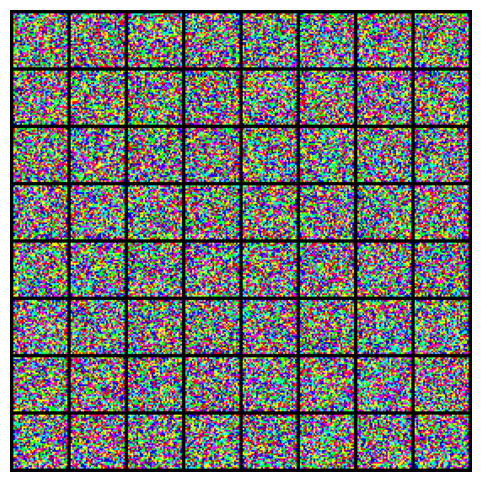

In [31]:
# Load the pre-trained checkpoint from disk
device = 'cuda'

# Load the pre-trained model checkpoint
ckpt = torch.load('ckpt.pth', map_location=device, weights_only=True)  # Set weights_only=True
score_model.load_state_dict(ckpt)

# Set sample batch size and number of steps
sample_batch_size = 64
num_steps = 1000

# Choose the Euler-Maruyama sampler
sampler = Euler_Maruyama_sampler

# Generate samples using the specified sampler
samples = sampler(
    score_model,
    marginal_prob_std_fn,
    diffusion_coeff_fn,
    sample_batch_size,
    num_steps=num_steps,
    device=device,
    y=None
)

# Clip samples to be in the range [0, 1]
samples = samples.clamp(0.0, 1.0)

# Visualize the generated samples
%matplotlib inline
import matplotlib.pyplot as plt
sample_grid = make_grid(samples, nrow=int(np.sqrt(sample_batch_size)))

# Plot the sample grid
plt.figure(figsize=(6, 6))
plt.axis('off')
plt.imshow(sample_grid.permute(1, 2, 0).cpu(), vmin=0., vmax=1.)
plt.show()


In [32]:
# Initialize the alternate U-Net model for training.
score_model = torch.nn.DataParallel(UNet_res(marginal_prob_std=marginal_prob_std_fn))
score_model = score_model.to(device)

# Set the number of training epochs, mini-batch size, and learning rate.
n_epochs = 150
batch_size = 256
lr = 1e-4

# Load the CIFAR10 dataset for training.
dataset = CIFAR10('.', train=True, transform=transforms.Compose([transforms.Resize((32, 32)), transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]), download=True)
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=4)

# Initialize the Adam optimizer with the specified learning rate.
optimizer = Adam(score_model.parameters(), lr=lr)
# Learning rate scheduler to adjust the learning rate during training.
scheduler = LambdaLR(optimizer, lr_lambda=lambda epoch: max(0.2, 0.98 ** epoch))

# Training loop over epochs.
tqdm_epoch = trange(n_epochs)
for epoch in tqdm_epoch:
    avg_loss = 0.
    num_items = 0
    # Iterate over mini-batches in the training data loader.
    for x, y in data_loader:
        #x = x.to(device)
        x, y = x.to(device), y.to(device)
        # Compute the loss for the current mini-batch.
        loss = loss_fn(score_model, x, marginal_prob_std_fn)
        # Zero the gradients, backpropagate, and update the model parameters.
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # Accumulate the total loss and the number of processed items.
        avg_loss += loss.item() * x.shape[0]
        num_items += x.shape[0]

    # Adjust the learning rate using the scheduler.
    scheduler.step()
    lr_current = scheduler.get_last_lr()[0]

    # Print the average loss and learning rate for the current epoch.
    print('{} Average Loss: {:5f} lr {:.1e}'.format(epoch, avg_loss / num_items, lr_current))
    tqdm_epoch.set_description('Average Loss: {:5f}'.format(avg_loss / num_items))

    # Save the model checkpoint after each epoch of training.
    torch.save(score_model.state_dict(), 'ckpt_res.pth')

Files already downloaded and verified


  0%|          | 0/150 [00:00<?, ?it/s]

<ipython-input-18-46cf9697f7ab>:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t = torch.tensor(t, device=device)


0 Average Loss: 6233.204697 lr 9.8e-05
1 Average Loss: 3278.869301 lr 9.6e-05
2 Average Loss: 2783.164241 lr 9.4e-05
3 Average Loss: 2546.492943 lr 9.2e-05
4 Average Loss: 2417.951554 lr 9.0e-05
5 Average Loss: 2343.173903 lr 8.9e-05
6 Average Loss: 2295.408545 lr 8.7e-05
7 Average Loss: 2264.048254 lr 8.5e-05
8 Average Loss: 2241.773687 lr 8.3e-05
9 Average Loss: 2226.872737 lr 8.2e-05
10 Average Loss: 2214.007786 lr 8.0e-05
11 Average Loss: 2205.386789 lr 7.8e-05
12 Average Loss: 2197.363682 lr 7.7e-05
13 Average Loss: 2193.107507 lr 7.5e-05
14 Average Loss: 2189.360206 lr 7.4e-05
15 Average Loss: 2184.698517 lr 7.2e-05
16 Average Loss: 2181.290160 lr 7.1e-05
17 Average Loss: 2177.724226 lr 7.0e-05
18 Average Loss: 2175.622719 lr 6.8e-05
19 Average Loss: 2174.518823 lr 6.7e-05
20 Average Loss: 2172.552281 lr 6.5e-05
21 Average Loss: 2170.617604 lr 6.4e-05
22 Average Loss: 2170.818376 lr 6.3e-05
23 Average Loss: 2168.491466 lr 6.2e-05
24 Average Loss: 2168.411287 lr 6.0e-05
25 Average

<ipython-input-33-ab8e71b8768b>:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load('ckpt_res.pth', map_location=device)
<ipython-input-18-46cf9697f7ab>:17: U

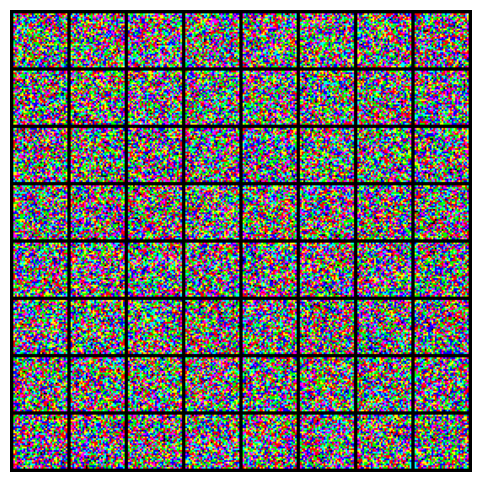

In [33]:
# Load the pre-trained checkpoint from disk.
device = 'cuda'

# Load the pre-trained model checkpoint
ckpt = torch.load('ckpt_res.pth', map_location=device)
score_model.load_state_dict(ckpt)

# Set sample batch size and number of steps
sample_batch_size = 64
num_steps = 1000

# Choose the Euler-Maruyama sampler
sampler = Euler_Maruyama_sampler

# Generate samples using the specified sampler
samples = sampler(score_model,
                  marginal_prob_std_fn,
                  diffusion_coeff_fn,
                  sample_batch_size,
                  num_steps=num_steps,
                  device=device,
                  y=None)

# Clip samples to be in the range [0, 1]
samples = samples.clamp(0.0, 1.0)

# Visualize the generated samples
%matplotlib inline
import matplotlib.pyplot as plt
sample_grid = make_grid(samples, nrow=int(np.sqrt(sample_batch_size)))

# Plot the sample grid
plt.figure(figsize=(6, 6))
plt.axis('off')
plt.imshow(sample_grid.permute(1, 2, 0).cpu(), vmin=0., vmax=1.)
plt.show()

In [34]:
class CrossAttention(nn.Module):
    def __init__(self, embed_dim, hidden_dim, context_dim=None, num_heads=1):
        """
        Initialize the CrossAttention module.

        Parameters:
        - embed_dim: The dimensionality of the output embeddings.
        - hidden_dim: The dimensionality of the hidden representations.
        - context_dim: The dimensionality of the context representations (if not self attention).
        - num_heads: Number of attention heads (currently supports 1 head).

        Note: For simplicity reasons, the implementation assumes 1-head attention.
        Feel free to implement multi-head attention using fancy tensor manipulations.
        """
        super(CrossAttention, self).__init__()

        self.hidden_dim = hidden_dim
        self.context_dim = context_dim
        self.embed_dim = embed_dim


        # Linear layer for query projection
        self.query = nn.Linear(hidden_dim, embed_dim, bias=False)

        # Check if self-attention or cross-attention
        if context_dim is None:
            self.self_attn = True
            self.key = nn.Linear(hidden_dim, embed_dim, bias=False)
            self.value = nn.Linear(hidden_dim, hidden_dim, bias=False)
        else:
            self.self_attn = False
            self.key = nn.Linear(context_dim, embed_dim, bias=False)
            self.value = nn.Linear(context_dim, hidden_dim, bias=False)

    def forward(self, tokens, context=None):
        """
        Forward pass of the CrossAttention module.

        Parameters:
        - tokens: Input tokens with shape [batch, sequence_len, hidden_dim].
        - context: Context information with shape [batch, context_seq_len, context_dim].
                    If self_attn is True, context is ignored.

        Returns:
        - ctx_vecs: Context vectors after attention with shape [batch, sequence_len, embed_dim].
        """

        if self.self_attn:
            # Self-attention case
            Q = self.query(tokens)
            K = self.key(tokens)
            V = self.value(tokens)
        else:
            # Cross-attention case
            Q = self.query(tokens)
            K = self.key(context)
            V = self.value(context)

        # Compute score matrices, attention matrices, and context vectors
        scoremats = torch.einsum("BTH,BSH->BTS", Q, K)  # Inner product of Q and K, a tensor
        attnmats = F.softmax(scoremats / math.sqrt(self.embed_dim), dim=-1)  # Softmax of scoremats
        ctx_vecs = torch.einsum("BTS,BSH->BTH", attnmats, V)  # Weighted average value vectors by attnmats

        return ctx_vecs

In [35]:
class TransformerBlock(nn.Module):
    """The transformer block that combines self-attn, cross-attn, and feed forward neural net"""
    def __init__(self, hidden_dim, context_dim):
        """
        Initialize the TransformerBlock.

        Parameters:
        - hidden_dim: The dimensionality of the hidden state.
        - context_dim: The dimensionality of the context tensor.

        Note: For simplicity, the self-attn and cross-attn use the same hidden_dim.
        """

        super(TransformerBlock, self).__init__()

        # Self-attention module
        self.attn_self = CrossAttention(hidden_dim, hidden_dim)

        # Cross-attention module
        self.attn_cross = CrossAttention(hidden_dim, hidden_dim, context_dim)

        # Layer normalization modules
        self.norm1 = nn.LayerNorm(hidden_dim)
        self.norm2 = nn.LayerNorm(hidden_dim)
        self.norm3 = nn.LayerNorm(hidden_dim)

        # Implement a 2-layer MLP with K * hidden_dim hidden units, and nn.GELU nonlinearity
        self.ffn = nn.Sequential(
            nn.Linear(hidden_dim, 3 * hidden_dim),
            nn.GELU(),
            nn.Linear(3 * hidden_dim, hidden_dim)
        )

    def forward(self, x, context=None):
        """
        Forward pass of the TransformerBlock.

        Parameters:
        - x: Input tensor with shape [batch, sequence_len, hidden_dim].
        - context: Context tensor with shape [batch, context_seq_len, context_dim].

        Returns:
        - x: Output tensor after passing through the TransformerBlock.
        """

        # Apply self-attention with layer normalization and residual connection
        x = self.attn_self(self.norm1(x)) + x

        # Apply cross-attention with layer normalization and residual connection
        x = self.attn_cross(self.norm2(x), context=context) + x

        # Apply feed forward neural network with layer normalization and residual connection
        x = self.ffn(self.norm3(x)) + x

        return x

In [36]:
class SpatialTransformer(nn.Module):
    def __init__(self, hidden_dim, context_dim):
        """
        Initialize the SpatialTransformer.

        Parameters:
        - hidden_dim: The dimensionality of the hidden state.
        - context_dim: The dimensionality of the context tensor.
        """
        super(SpatialTransformer, self).__init__()

        # TransformerBlock for spatial transformation
        self.transformer = TransformerBlock(hidden_dim, context_dim)

    def forward(self, x, context=None):
        """
        Forward pass of the SpatialTransformer.

        Parameters:
        - x: Input tensor with shape [batch, channels, height, width].
        - context: Context tensor with shape [batch, context_seq_len, context_dim].

        Returns:
        - x: Output tensor after applying spatial transformation.
        """
        b, c, h, w = x.shape
        x_in = x

        # Combine the spatial dimensions and move the channel dimension to the end
        x = rearrange(x, "b c h w -> b (h w) c")

        # Apply the sequence transformer
        x = self.transformer(x, context)

        # Reverse the process
        x = rearrange(x, 'b (h w) c -> b c h w', h=h, w=w)

        # Residue connection
        return x + x_in

In [37]:
class UNet_Tranformer(nn.Module):
    """A time-dependent score-based model built upon U-Net architecture."""
    def __init__(self, marginal_prob_std, channels=[32, 64, 128, 256], embed_dim=256,
                 text_dim=256, nClass=10):
        """
        Initialize a time-dependent score-based network.

        Parameters:
        - marginal_prob_std: A function that gives the standard deviation
          of the perturbation kernel p_{0t}(x(t) | x(0)).
        - channels: The number of channels for feature maps of each resolution.
        - embed_dim: The dimensionality of Gaussian random feature embeddings of time.
        - text_dim: The embedding dimension of text/digits.
        - nClass: Number of classes to model.
        """
        super().__init__()

        # Gaussian random feature embedding layer for time
        self.time_embed = nn.Sequential(
            GaussianFourierProjection(embed_dim=embed_dim),
            nn.Linear(embed_dim, embed_dim)
        )

        # Encoding layers where the resolution decreases
        self.conv1 = nn.Conv2d(3, channels[0], kernel_size=3, stride=1, padding=1, bias=False)  # Updated to 3 channels
        self.dense1 = Dense(embed_dim, channels[0])
        self.gnorm1 = nn.GroupNorm(4, num_channels=channels[0])

        self.conv2 = nn.Conv2d(channels[0], channels[1], kernel_size=3, stride=2, padding=1, bias=False)
        self.dense2 = Dense(embed_dim, channels[1])
        self.gnorm2 = nn.GroupNorm(32, num_channels=channels[1])

        self.conv3 = nn.Conv2d(channels[1], channels[2], kernel_size=3, stride=2, padding=1, bias=False)
        self.dense3 = Dense(embed_dim, channels[2])
        self.gnorm3 = nn.GroupNorm(32, num_channels=channels[2])
        self.attn3 = SpatialTransformer(channels[2], text_dim)

        self.conv4 = nn.Conv2d(channels[2], channels[3], kernel_size=3, stride=2, padding=1, bias=False)
        self.dense4 = Dense(embed_dim, channels[3])
        self.gnorm4 = nn.GroupNorm(32, num_channels=channels[3])
        self.attn4 = SpatialTransformer(channels[3], text_dim)

        # Decoding layers where the resolution increases
        self.tconv4 = nn.ConvTranspose2d(channels[3], channels[2], kernel_size=3, stride=2, padding=1, output_padding=1, bias=False)
        self.dense5 = Dense(embed_dim, channels[2])
        self.tgnorm4 = nn.GroupNorm(32, num_channels=channels[2])

        self.tconv3 = nn.ConvTranspose2d(channels[2], channels[1], kernel_size=3, stride=2, padding=1, output_padding=1, bias=False)
        self.dense6 = Dense(embed_dim, channels[1])
        self.tgnorm3 = nn.GroupNorm(32, num_channels=channels[1])

        self.tconv2 = nn.ConvTranspose2d(channels[1], channels[0], kernel_size=3, stride=2, padding=1, output_padding=1, bias=False)
        self.dense7 = Dense(embed_dim, channels[0])
        self.tgnorm2 = nn.GroupNorm(32, num_channels=channels[0])

        self.tconv1 = nn.ConvTranspose2d(channels[0], 3, kernel_size=3, stride=1, padding=1)  # Fixed to output 3 channels

        # The swish activation function
        self.act = nn.SiLU()
        self.marginal_prob_std = marginal_prob_std
        self.cond_embed = nn.Embedding(nClass, text_dim)

    def forward(self, x, t, y=None):
        """
        Forward pass of the UNet_Transformer model.

        Parameters:
        - x: Input tensor.
        - t: Time tensor.
        - y: Target tensor.

        Returns:
        - h: Output tensor after passing through the UNet_Transformer architecture.
        """
        # Obtain the Gaussian random feature embedding for t
        embed = self.act(self.time_embed(t))
        y_embed = self.cond_embed(y).unsqueeze(1)

        # Encoding path
        h1 = self.conv1(x) + self.dense1(embed)
        h1 = self.act(self.gnorm1(h1))
        h2 = self.conv2(h1) + self.dense2(embed)
        h2 = self.act(self.gnorm2(h2))
        h3 = self.conv3(h2) + self.dense3(embed)
        h3 = self.act(self.gnorm3(h3))
        h3 = self.attn3(h3, y_embed)
        h4 = self.conv4(h3) + self.dense4(embed)
        h4 = self.act(self.gnorm4(h4))
        h4 = self.attn4(h4, y_embed)

        # Decoding path
        h = self.tconv4(h4) + self.dense5(embed)
        h = self.act(self.tgnorm4(h))
        h = self.tconv3(h + h3) + self.dense6(embed)
        h = self.act(self.tgnorm3(h))
        h = self.tconv2(h + h2) + self.dense7(embed)
        h = self.act(self.tgnorm2(h))
        h = self.tconv1(h + h1)

        # Normalize output
        h = h / self.marginal_prob_std(t)[:, None, None, None]
        return h


In [38]:
def loss_fn_cond(model, x, y, marginal_prob_std, eps=1e-5):
    """
    The loss function for training score-based generative models with conditional information.

    Parameters:
    - model: A PyTorch model instance that represents a time-dependent score-based model.
    - x: A mini-batch of training data.
    - y: Conditional information (target tensor).
    - marginal_prob_std: A function that gives the standard deviation of the perturbation kernel.
    - eps: A tolerance value for numerical stability.

    Returns:
    - loss: The calculated loss.
    """
    # Sample time uniformly in the range [eps, 1-eps]
    random_t = torch.rand(x.shape[0], device=x.device) * (1. - eps) + eps
    # Generate random noise with the same shape as the input
    z = torch.randn_like(x)
    # Compute the standard deviation of the perturbation kernel at the sampled time
    std = marginal_prob_std(random_t)
    # Perturb the input data with the generated noise and scaled by the standard deviation
    perturbed_x = x + z * std[:, None, None, None]
    # Get the model's score for the perturbed input, considering conditional information
    score = model(perturbed_x, random_t, y=y)
    # Calculate the loss using the score and perturbation
    loss = torch.mean(torch.sum((score * std[:, None, None, None] + z)**2, dim=(1, 2, 3)))
    return loss

In [ ]:
# Specify whether to continue training or initialize a new model

continue_training = False # Either True or False

if not continue_training:

    # Initialize a new UNet with Transformer model
    score_model = torch.nn.DataParallel(UNet_Tranformer(marginal_prob_std=marginal_prob_std_fn))
    score_model = score_model.to(device)

# Set training hyperparameters
n_epochs =   200   #{'type':'integer'}
batch_size =  256 #{'type':'integer'}
lr = 1e-4         #{'type':'number'}

# Load the CIFAR10 dataset and create a data loader
dataset = CIFAR10('.', train=True, transform=transforms.Compose([transforms.Resize((32, 32)), transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]), download=True)
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=4)

# Define the optimizer and learning rate scheduler
optimizer = Adam(score_model.parameters(), lr=lr)
scheduler = LambdaLR(optimizer, lr_lambda=lambda epoch: max(0.2, 0.98 ** epoch))

# Use tqdm to display a progress bar over epochs
tqdm_epoch = trange(n_epochs)
for epoch in tqdm_epoch:
    avg_loss = 0.
    num_items = 0

    # Iterate over batches in the data loader
    for x, y in tqdm(data_loader):
        #x = x.to(device)
        x, y = x.to(device), y.to(device)

        # Compute the loss using the conditional score-based model
        loss = loss_fn_cond(score_model, x, y, marginal_prob_std_fn)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        avg_loss += loss.item() * x.shape[0]
        num_items += x.shape[0]

    # Adjust learning rate using the scheduler
    scheduler.step()
    lr_current = scheduler.get_last_lr()[0]

    # Print epoch information including average loss and current learning rate
    print('{} Average Loss: {:5f} lr {:.1e}'.format(epoch, avg_loss / num_items, lr_current))
    tqdm_epoch.set_description('Average Loss: {:5f}'.format(avg_loss / num_items))

    # Save the model checkpoint after each epoch of training
    torch.save(score_model.state_dict(), 'ckpt_transformer.pth')

Files already downloaded and verified


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/196 [00:00<?, ?it/s]

<ipython-input-18-46cf9697f7ab>:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t = torch.tensor(t, device=device)


0 Average Loss: 3383.167417 lr 9.8e-05


  0%|          | 0/196 [00:00<?, ?it/s]

1 Average Loss: 1101.728203 lr 9.6e-05


  0%|          | 0/196 [00:00<?, ?it/s]

2 Average Loss: 747.198198 lr 9.4e-05


  0%|          | 0/196 [00:00<?, ?it/s]

3 Average Loss: 574.175918 lr 9.2e-05


  0%|          | 0/196 [00:00<?, ?it/s]

4 Average Loss: 467.284977 lr 9.0e-05


  0%|          | 0/196 [00:00<?, ?it/s]

5 Average Loss: 397.440165 lr 8.9e-05


  0%|          | 0/196 [00:00<?, ?it/s]

6 Average Loss: 345.516981 lr 8.7e-05


  0%|          | 0/196 [00:00<?, ?it/s]

7 Average Loss: 309.835345 lr 8.5e-05


  0%|          | 0/196 [00:00<?, ?it/s]

8 Average Loss: 280.216243 lr 8.3e-05


  0%|          | 0/196 [00:00<?, ?it/s]

9 Average Loss: 255.259854 lr 8.2e-05


  0%|          | 0/196 [00:00<?, ?it/s]

10 Average Loss: 237.150189 lr 8.0e-05


  0%|          | 0/196 [00:00<?, ?it/s]

11 Average Loss: 221.611695 lr 7.8e-05


  0%|          | 0/196 [00:00<?, ?it/s]

12 Average Loss: 207.256761 lr 7.7e-05


  0%|          | 0/196 [00:00<?, ?it/s]

13 Average Loss: 197.355369 lr 7.5e-05


  0%|          | 0/196 [00:00<?, ?it/s]

14 Average Loss: 190.293180 lr 7.4e-05


  0%|          | 0/196 [00:00<?, ?it/s]

15 Average Loss: 183.672296 lr 7.2e-05


  0%|          | 0/196 [00:00<?, ?it/s]

16 Average Loss: 180.141859 lr 7.1e-05


  0%|          | 0/196 [00:00<?, ?it/s]

17 Average Loss: 174.325939 lr 7.0e-05


  0%|          | 0/196 [00:00<?, ?it/s]

18 Average Loss: 172.931417 lr 6.8e-05


  0%|          | 0/196 [00:00<?, ?it/s]

19 Average Loss: 169.082952 lr 6.7e-05


  0%|          | 0/196 [00:00<?, ?it/s]

20 Average Loss: 165.550875 lr 6.5e-05


  0%|          | 0/196 [00:00<?, ?it/s]

21 Average Loss: 161.179175 lr 6.4e-05


  0%|          | 0/196 [00:00<?, ?it/s]

22 Average Loss: 159.516787 lr 6.3e-05


  0%|          | 0/196 [00:00<?, ?it/s]

23 Average Loss: 161.121083 lr 6.2e-05


  0%|          | 0/196 [00:00<?, ?it/s]

24 Average Loss: 158.043431 lr 6.0e-05


  0%|          | 0/196 [00:00<?, ?it/s]

25 Average Loss: 153.575534 lr 5.9e-05


  0%|          | 0/196 [00:00<?, ?it/s]

26 Average Loss: 152.800841 lr 5.8e-05


  0%|          | 0/196 [00:00<?, ?it/s]

27 Average Loss: 152.280647 lr 5.7e-05


  0%|          | 0/196 [00:00<?, ?it/s]

28 Average Loss: 151.161660 lr 5.6e-05


  0%|          | 0/196 [00:00<?, ?it/s]

29 Average Loss: 148.745402 lr 5.5e-05


  0%|          | 0/196 [00:00<?, ?it/s]

30 Average Loss: 149.265693 lr 5.3e-05


  0%|          | 0/196 [00:00<?, ?it/s]

31 Average Loss: 147.410575 lr 5.2e-05


  0%|          | 0/196 [00:00<?, ?it/s]

32 Average Loss: 148.367690 lr 5.1e-05


  0%|          | 0/196 [00:00<?, ?it/s]

33 Average Loss: 148.007272 lr 5.0e-05


  0%|          | 0/196 [00:00<?, ?it/s]

34 Average Loss: 145.336237 lr 4.9e-05


  0%|          | 0/196 [00:00<?, ?it/s]

35 Average Loss: 146.224633 lr 4.8e-05


  0%|          | 0/196 [00:00<?, ?it/s]

36 Average Loss: 144.414521 lr 4.7e-05


  0%|          | 0/196 [00:00<?, ?it/s]

37 Average Loss: 144.158154 lr 4.6e-05


  0%|          | 0/196 [00:00<?, ?it/s]

38 Average Loss: 142.734139 lr 4.5e-05


  0%|          | 0/196 [00:00<?, ?it/s]

39 Average Loss: 142.480061 lr 4.5e-05


  0%|          | 0/196 [00:00<?, ?it/s]

40 Average Loss: 141.405402 lr 4.4e-05


  0%|          | 0/196 [00:00<?, ?it/s]

41 Average Loss: 140.650561 lr 4.3e-05


  0%|          | 0/196 [00:00<?, ?it/s]

42 Average Loss: 139.986971 lr 4.2e-05


  0%|          | 0/196 [00:00<?, ?it/s]

43 Average Loss: 141.310153 lr 4.1e-05


  0%|          | 0/196 [00:00<?, ?it/s]

44 Average Loss: 139.862911 lr 4.0e-05


  0%|          | 0/196 [00:00<?, ?it/s]

45 Average Loss: 139.770807 lr 3.9e-05


  0%|          | 0/196 [00:00<?, ?it/s]

46 Average Loss: 141.245538 lr 3.9e-05


  0%|          | 0/196 [00:00<?, ?it/s]

47 Average Loss: 136.530205 lr 3.8e-05


  0%|          | 0/196 [00:00<?, ?it/s]

48 Average Loss: 137.818326 lr 3.7e-05


  0%|          | 0/196 [00:00<?, ?it/s]

49 Average Loss: 137.945243 lr 3.6e-05


  0%|          | 0/196 [00:00<?, ?it/s]

50 Average Loss: 135.221146 lr 3.6e-05


  0%|          | 0/196 [00:00<?, ?it/s]

51 Average Loss: 137.296177 lr 3.5e-05


  0%|          | 0/196 [00:00<?, ?it/s]

52 Average Loss: 137.442983 lr 3.4e-05


  0%|          | 0/196 [00:00<?, ?it/s]

53 Average Loss: 135.975603 lr 3.4e-05


  0%|          | 0/196 [00:00<?, ?it/s]

54 Average Loss: 136.311924 lr 3.3e-05


  0%|          | 0/196 [00:00<?, ?it/s]

55 Average Loss: 135.995930 lr 3.2e-05


  0%|          | 0/196 [00:00<?, ?it/s]

56 Average Loss: 135.516197 lr 3.2e-05


  0%|          | 0/196 [00:00<?, ?it/s]

57 Average Loss: 133.134264 lr 3.1e-05


  0%|          | 0/196 [00:00<?, ?it/s]

58 Average Loss: 133.899592 lr 3.0e-05


  0%|          | 0/196 [00:00<?, ?it/s]

59 Average Loss: 133.440061 lr 3.0e-05


  0%|          | 0/196 [00:00<?, ?it/s]

60 Average Loss: 133.472667 lr 2.9e-05


  0%|          | 0/196 [00:00<?, ?it/s]

61 Average Loss: 131.838921 lr 2.9e-05


  0%|          | 0/196 [00:00<?, ?it/s]

62 Average Loss: 132.563702 lr 2.8e-05


  0%|          | 0/196 [00:00<?, ?it/s]

63 Average Loss: 131.064978 lr 2.7e-05


  0%|          | 0/196 [00:00<?, ?it/s]

64 Average Loss: 131.082761 lr 2.7e-05


  0%|          | 0/196 [00:00<?, ?it/s]

65 Average Loss: 132.431150 lr 2.6e-05


  0%|          | 0/196 [00:00<?, ?it/s]

66 Average Loss: 130.147858 lr 2.6e-05


  0%|          | 0/196 [00:00<?, ?it/s]

67 Average Loss: 130.391550 lr 2.5e-05


  0%|          | 0/196 [00:00<?, ?it/s]

68 Average Loss: 131.181721 lr 2.5e-05


  0%|          | 0/196 [00:00<?, ?it/s]

69 Average Loss: 130.532106 lr 2.4e-05


  0%|          | 0/196 [00:00<?, ?it/s]

70 Average Loss: 129.239376 lr 2.4e-05


  0%|          | 0/196 [00:00<?, ?it/s]

71 Average Loss: 128.940619 lr 2.3e-05


  0%|          | 0/196 [00:00<?, ?it/s]

72 Average Loss: 129.270403 lr 2.3e-05


  0%|          | 0/196 [00:00<?, ?it/s]

73 Average Loss: 127.295462 lr 2.2e-05


  0%|          | 0/196 [00:00<?, ?it/s]

74 Average Loss: 130.420826 lr 2.2e-05


  0%|          | 0/196 [00:00<?, ?it/s]

75 Average Loss: 128.944893 lr 2.2e-05


  0%|          | 0/196 [00:00<?, ?it/s]

76 Average Loss: 128.872690 lr 2.1e-05


  0%|          | 0/196 [00:00<?, ?it/s]

77 Average Loss: 128.063024 lr 2.1e-05


  0%|          | 0/196 [00:00<?, ?it/s]

78 Average Loss: 127.358367 lr 2.0e-05


  0%|          | 0/196 [00:00<?, ?it/s]

79 Average Loss: 127.034130 lr 2.0e-05


  0%|          | 0/196 [00:00<?, ?it/s]

80 Average Loss: 126.677598 lr 2.0e-05


  0%|          | 0/196 [00:00<?, ?it/s]

81 Average Loss: 126.697575 lr 2.0e-05


  0%|          | 0/196 [00:00<?, ?it/s]

82 Average Loss: 127.705127 lr 2.0e-05


  0%|          | 0/196 [00:00<?, ?it/s]

83 Average Loss: 126.242137 lr 2.0e-05


  0%|          | 0/196 [00:00<?, ?it/s]

84 Average Loss: 125.100314 lr 2.0e-05


  0%|          | 0/196 [00:00<?, ?it/s]

85 Average Loss: 126.941134 lr 2.0e-05


  0%|          | 0/196 [00:00<?, ?it/s]

86 Average Loss: 126.253195 lr 2.0e-05


  0%|          | 0/196 [00:00<?, ?it/s]

87 Average Loss: 126.903580 lr 2.0e-05


  0%|          | 0/196 [00:00<?, ?it/s]

88 Average Loss: 124.665136 lr 2.0e-05


  0%|          | 0/196 [00:00<?, ?it/s]

89 Average Loss: 125.712192 lr 2.0e-05


  0%|          | 0/196 [00:00<?, ?it/s]

90 Average Loss: 127.019766 lr 2.0e-05


  0%|          | 0/196 [00:00<?, ?it/s]

91 Average Loss: 125.497496 lr 2.0e-05


  0%|          | 0/196 [00:00<?, ?it/s]

92 Average Loss: 124.779630 lr 2.0e-05


  0%|          | 0/196 [00:00<?, ?it/s]

93 Average Loss: 125.481875 lr 2.0e-05


  0%|          | 0/196 [00:00<?, ?it/s]

94 Average Loss: 123.417036 lr 2.0e-05


  0%|          | 0/196 [00:00<?, ?it/s]

95 Average Loss: 124.266081 lr 2.0e-05


  0%|          | 0/196 [00:00<?, ?it/s]

96 Average Loss: 126.206312 lr 2.0e-05


  0%|          | 0/196 [00:00<?, ?it/s]

97 Average Loss: 124.339732 lr 2.0e-05


  0%|          | 0/196 [00:00<?, ?it/s]

98 Average Loss: 124.109371 lr 2.0e-05


  0%|          | 0/196 [00:00<?, ?it/s]

99 Average Loss: 123.579624 lr 2.0e-05


  0%|          | 0/196 [00:00<?, ?it/s]

100 Average Loss: 123.491524 lr 2.0e-05


  0%|          | 0/196 [00:00<?, ?it/s]

101 Average Loss: 123.671982 lr 2.0e-05


  0%|          | 0/196 [00:00<?, ?it/s]

In [ ]:
# Load model and generate samples
score_model = torch.nn.DataParallel(UNet_Tranformer(marginal_prob_std=marginal_prob_std_fn))
ckpt = torch.load('ckpt_transformer.pth', map_location=device)
score_model.load_state_dict(ckpt)
score_model.eval()

target_class = 3
samples = Euler_Maruyama_sampler(
    score_model,
    marginal_prob_std_fn,
    diffusion_coeff_fn,
    batch_size=64,
    x_shape=(3, 32, 32),
    num_steps=250,
    device=device,
    y=target_class * torch.ones(64, dtype=torch.long, device=device)
)

# Visualize samples
samples = samples.clamp(0.0, 1.0)
sample_grid = make_grid(samples, nrow=8)
plt.figure(figsize=(8, 8))
plt.axis('off')
plt.imshow(sample_grid.permute(1, 2, 0).cpu(), vmin=0., vmax=1.)
plt.title(f"Generated Samples for Class {target_class}")
plt.show()
